# Assigment 1
- Guillem
- Anna
- Johnny

● Test different amounts of local features. What performs best?  
● Use dense SIFT instead of detected keypoints. Conclusions?  
● Test different amounts of codebook sizes k. What performs best?  
● Test different values of k for the k-nn classifier. What performs best?  
● Test other distances in k-nn classifier. Does that make a difference? Why?  
● Play with reducing dimensionality. Conclusions?  
● Cross-validate everything (topic covered on Wednesday)  

# 1. Import libraries

In [20]:

import cv2
import numpy as np
import pickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from functools import partial
import time
import pandas as pd
from tqdm.notebook import trange, tqdm
import optuna
from optuna.visualization.matplotlib import plot_contour, plot_edf, plot_intermediate_values, plot_optimization_history, plot_parallel_coordinate, plot_param_importances, plot_slice
import os
from optuna.samplers import TPESampler
import concurrent.futures

%matplotlib inline


# 2. Read the train and test files

In [21]:
train_images_filenames = pickle.load(
    open('MIT_split/train_images_filenames_unix.dat', 'rb'))
test_images_filenames = pickle.load(
    open('MIT_split/test_images_filenames_unix.dat', 'rb'))
# train_images_filenames = ['..' + n[15:] for n in train_images_filenames] original
# test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]  original
train_images_filenames = [n[16:] for n in train_images_filenames]
test_images_filenames = [n[16:] for n in test_images_filenames]
train_labels = pickle.load(open('MIT_split/train_labels_unix.dat', 'rb'))
test_labels = pickle.load(open('MIT_split/test_labels_unix.dat', 'rb'))


In [22]:
train_images_filenames[12]


'MIT_split/train/Opencountry/fie26.jpg'

# 3. Distribution Data

In [23]:
unique_classes, counts = np.unique(train_labels, return_counts=True)
total_count = sum(counts)
train_class_proportions = counts / total_count

# Calculate the class proportions for the test set
unique_classes, counts = np.unique(test_labels, return_counts=True)
total_count = sum(counts)
test_class_proportions = counts / total_count

# Print the class proportions for the train and test sets
print("Train set class proportions:", train_class_proportions)
print("Test set class proportions:", test_class_proportions)


Train set class proportions: [0.15523658 0.12971823 0.12068049 0.09782031 0.11376927 0.13822435
 0.11270601 0.13184476]
Test set class proportions: [0.14622057 0.14374226 0.12515489 0.09417596 0.11648079 0.14126394
 0.09913259 0.133829  ]


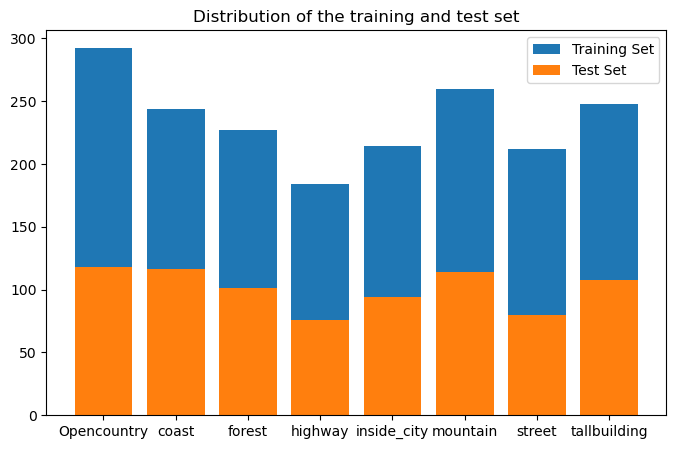

In [24]:
unique_labels = np.unique(train_labels + test_labels)
train_count = [np.sum(np.array(train_labels) == lab) for lab in unique_labels]
test_count = [np.sum(np.array(test_labels) == lab) for lab in unique_labels]


# distribution of the training and test set
def plot_distribution(train_count, test_count, unique_labels):
    plt.figure(figsize=(8, 5))
    plt.title("Distribution of the training and test set")
    plt.bar(unique_labels, train_count, label="Training Set")
    plt.bar(unique_labels, test_count, label="Test Set")
    plt.legend()
    plt.show()


plot_distribution(train_count, test_count, unique_labels)


# TODO: EXPLANATION
To check if a dataset is unbalanced, we can calculate the proportion of each class in the dataset and compare the proportions. If the proportions of the classes are significantly different, then the dataset is likely to be unbalanced.
In this case, the dataset is balanced

# 4. Descriptors

In [25]:
class KAZE:
    def __init__(self, threshold=0.001):
        self.extractor = cv2.KAZE_create(threshold=threshold)

    def extract_features(self, image):
        keypoints, descriptors = self.extractor.detectAndCompute(image, None)
        return descriptors


class AKAZE:
    def __init__(self, threshold=0.001):
        self.extractor = cv2.AKAZE_create(threshold=threshold)

    def extract_features(self, image):
        keypoints, descriptors = self.extractor.detectAndCompute(image, None)
        return descriptors


class SIFT:
    def __init__(self, n_features=300):
        self.extractor = cv2.SIFT_create(nfeatures=n_features)

    def extract_features(self, image):
        keypoints, descriptors = self.extractor.detectAndCompute(image, None)
        return descriptors


class DenseSIFT:
    def __init__(self, n_features=300, step_size=10, patch_size=10):
        self.extractor = cv2.SIFT_create(nfeatures=n_features)
        self.step_div_size = step_size
        self.num_sizes = patch_size

    def extract_features(self, image):
        descriptors = []
        init_step_size_x = max(image.shape[1] // self.step_div_size, 16)
        init_step_size_y = max(image.shape[0] // self.step_div_size, 16)
        
        for i in range(1, self.num_sizes+1):
            current_step_x = init_step_size_x * i
            current_step_y = init_step_size_y * i
            avg_size = (current_step_x + current_step_y) // 2
            descriptors += [cv2.KeyPoint(x, y, avg_size) for y in range(0, image.shape[0], current_step_y) 
                                                    for x in range(0, image.shape[1], current_step_x)]
        descriptors = self.extractor.compute(image, descriptors)[1]
        return descriptors


class ORB:
    def __init__(self, n_features=100):
        self.extractor = cv2.ORB_create(nfeatures=n_features)

    def extract_features(self, image):
        keypoints, descriptors = self.extractor.detectAndCompute(image, None)
        return descriptors


class BRISK:
    def __init__(self, n_features=100):
        self.extractor = cv2.BRISK_create(nfeatures=n_features)

    def extract_features(self, image):
        keypoints, descriptors = self.extractor.detectAndCompute(image, None)
        return descriptors


In [26]:
feature_extractors = {
    "SIFT": SIFT,
    "DenseSIFT": DenseSIFT,
    "KAZE": KAZE,
    "AKAZE": AKAZE,
    "ORB": ORB,
    "BRISK": BRISK
}


# 5. Hyperparameters

In [27]:
def extract_features(images_filenames, train_labels, feature_extractor, extract_features=True):
    descriptors = list()
    label_per_descriptor = list()
    images = list()

    for filename, labels in zip(train_images_filenames, train_labels):
        ima = cv2.imread(filename)
        gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
        if extract_features:
            des = feature_extractor.extract_features(gray)
            descriptors.append(des)
        else:
            images.append(gray)
        label_per_descriptor.append(labels)
    if not extract_features:
        return images, label_per_descriptor
    else:
        return descriptors, label_per_descriptor


# 6. bag of visual words

In [28]:
def cluster_local_features(features, n_clusters):
    codebook = MiniBatchKMeans(n_clusters=n_clusters, verbose=False, batch_size=n_clusters *
                               20, compute_labels=False, reassignment_ratio=10**-4, random_state=42)
    codebook.fit(features)
    return codebook


# 7. KNN Classifier

In [29]:
DESCRIPTOR = feature_extractors["SIFT"]()
train_descriptors, train_labels_descrip = extract_features(
    train_images_filenames, train_labels, DESCRIPTOR)
test_descriptors, test_labels_descrip = extract_features(
    test_images_filenames, test_labels, DESCRIPTOR)


In [30]:
stack = np.vstack(train_descriptors)
codebook = cluster_local_features(stack, n_clusters=100)


In [31]:
def compute_histogram(assigned_clusters, num_clusters):
    bag_visual_words = np.zeros(
        (len(assigned_clusters), num_clusters), dtype=np.float32)
    for i in range(len(assigned_clusters)):
        hist_i, _ = np.histogram(
            assigned_clusters[i], bins=num_clusters, range=(0, num_clusters))
        bag_visual_words[i, :] = normalize(hist_i.reshape(1, -1), norm='l2')
    return bag_visual_words


def obtain_histogram_visual_words(features, tr_lengths=None, codebook=None):
    if tr_lengths is None:
        tr_lengths = [len(feature) for feature in features]
        features = np.vstack(features)
    assigned_labels = codebook.predict(features)
    lengths = np.array(
        [0]+[descriptor_length for descriptor_length in tr_lengths])
    lengths = np.cumsum(lengths)
    splitted_labels = [assigned_labels[lengths[i]:lengths[i+1]]
                       for i in range(len(lengths)-1)]
    return compute_histogram(splitted_labels, codebook.cluster_centers_.shape[0])


In [32]:
visual_words_train = obtain_histogram_visual_words(
    train_descriptors, codebook=codebook)
visual_words_test = obtain_histogram_visual_words(
    test_descriptors, codebook=codebook)


In [33]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1, metric='euclidean')
knn.fit(visual_words_train, train_labels)


KNeighborsClassifier(metric='euclidean', n_jobs=-1)

In [34]:
# Define cross-validation functions
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import balanced_accuracy_score

cv_strategies = {
    "kfold": KFold,
    "stratified": StratifiedKFold,
    "repeats": RepeatedStratifiedKFold
}

metrics = {
    "balanced_accuracy": balanced_accuracy_score
}


class BoVWClassifier(BaseEstimator, ClassifierMixin):
    """ Image classifier using Bag of Visual Words. """

    def __init__(self, clustering_method, classifier, reduction_method):
        self.clustering_method = clustering_method
        self.classifier = classifier
        self.reduction_method = reduction_method
        self.codebook = None

    def fit(self, features, labels, sample_weight=None):
        tr_lengths = [len(feature) for feature in features]
        features = np.vstack(features)
        self.codebook = self.clustering_method(features)
        tr_hist = obtain_histogram_visual_words(
            features, tr_lengths, self.codebook)
        tr_hist_reduced = self.reduction_method.fit_transform(tr_hist, labels)
        self.classifier.fit(tr_hist_reduced, labels)

    def fit_transform(self, features, labels):
        self.fit(features, labels)
        return self.predict(features)

    def predict_proba(self, features):
        te_lengths = [len(feature) for feature in features]
        features = np.vstack(features)

        te_hist = obtain_histogram_visual_words(
            features, te_lengths, self.codebook)
        te_hist_reduced = self.reduction_method.transform(te_hist)
        cls = self.classifier.predict_proba(te_hist_reduced)
        return cls

    def predict(self, features):
        te_lengths = [len(feature) for feature in features]
        features = np.vstack(features)

        te_hist = obtain_histogram_visual_words(
            features, te_lengths, self.codebook)
        te_hist_reduced = self.reduction_method.transform(te_hist)
        cls = self.classifier.predict(te_hist_reduced)
        return cls

    def score(self, X, y=None):
        return (sum(self.predict(X)))

    def score_accuracy(self, X, y):
        return 100*self.score(X, y)/len(y)


class FastCrossValidator:
    """ Cross-validator class """

    def __init__(self, cv_method, metric_name, trainer, labels):
        """ 
        Params:
        - cv_method (function): Clustering function that when called returns a codebook.
        - classifier (Classifier like KNN, LogisticRegression,...)
        - reduction_method (None/PCA/LDA/Isomap)
        """
        self.cv_method = cv_method
        self.metric_name = metric_name
        self.trainer = trainer
        self.labels = np.array(labels)

    def cross_validate(self, feature_list, labels, n_jobs=-1):
        return cross_val_score(self.trainer, feature_list, labels, scoring=self.metric_name, cv=self.cv_method, n_jobs=n_jobs)


class Dummy():
    """ Dummy dimensionality reduction method that keeps all the original features. """

    def fit_transform(self, features, labels):
        return features

    def transform(self, features):
        return features


classifiers = {"KNN": KNeighborsClassifier}

dim_reduction = {
    "None": Dummy,
    "PCA": PCA,
    "LDA": LinearDiscriminantAnalysis,
}


In [35]:
visual_words_test = obtain_histogram_visual_words(
    test_descriptors, codebook=codebook)


In [36]:
accuracy = 100*knn.score(visual_words_test, test_labels)
print(accuracy)


13.506815365551425


# 8. Dimensonality reduction

In [37]:
pca = PCA(n_components=64)
VWpca = pca.fit_transform(visual_words_train)
knnpca = KNeighborsClassifier(n_neighbors=5, n_jobs=-1, metric='euclidean')
knnpca.fit(VWpca, train_labels)
vwtestpca = pca.transform(visual_words_test)
accuracy = 100*knnpca.score(vwtestpca, test_labels)
print(accuracy)


11.771995043370508


In [38]:
lda = LinearDiscriminantAnalysis(n_components=7)
VWlda = lda.fit_transform(visual_words_train, train_labels)
knnlda = KNeighborsClassifier(n_neighbors=5, n_jobs=-1, metric='euclidean')
knnlda.fit(VWlda, train_labels)
vwtestlda = lda.transform(visual_words_test)
accuracy = 100*knnlda.score(vwtestlda, test_labels)
print(accuracy)


12.267657992565056


# 9. Experiments

# 9.1 
● Test different amounts of local features. What performs best?  


In [39]:
def compare_local_features(trial):
    search_metric = "balanced_accuracy"
    cv_strategy = cv_strategies["stratified"](n_splits=10)
    n_features = int(trial.suggest_int('n_features', 50, 1000))
    DESCRIPTOR = feature_extractors["SIFT"](n_features=n_features)
    train_descriptors, train_labels_descrip = extract_features(
        train_images_filenames, train_labels, DESCRIPTOR)
    test_descriptors, test_labels_descrip = extract_features(
        test_images_filenames, test_labels, DESCRIPTOR)

    clustering = partial(cluster_local_features, n_clusters=128)
    dim_reduction_type = dim_reduction["None"]()
    classifier = classifiers["KNN"](
        n_neighbors=5, n_jobs=8, metric='euclidean')

    ex_trainer = BoVWClassifier(clustering, classifier, dim_reduction_type)
    ex_cv = FastCrossValidator(
        cv_strategy, search_metric, ex_trainer, np.unique(train_labels_descrip))
    ex_metrics = ex_cv.cross_validate(
        train_descriptors, train_labels_descrip, n_jobs=8)

    return ex_metrics.mean()


# random, grid search all of you want sampler https://optuna.readthedocs.io/en/stable/reference/samplers/index.html
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="SIFT", direction='maximize', sampler=sampler, storage="sqlite:///bbdd.db")
study.optimize(compare_local_features, n_trials=100,
               n_jobs=8, gc_after_trial=True)

df = study.trials_dataframe()
df.to_csv("sift.csv")
trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))


[I 2022-12-30 00:08:02,554] A new study created in RDB with name: SIFT


In [ ]:
plot_optimization_history(study)


# 9.2
Use dense SIFT instead of detected keypoints. Conclusions?  

In [ ]:

def compare_models(trial):
    search_metric = "balanced_accuracy"
    cv_strategy = cv_strategies["stratified"](n_splits=10)
    step_size = int(trial.suggest_int('step_size', 2, 100))
    patch_size = int(trial.suggest_int('patch_size', 1, 5))
    DESCRIPTOR = feature_extractors["DenseSIFT"](
        step_size=step_size, patch_size=patch_size)

    train_descriptors, train_labels_descrip = extract_features(
        train_images_filenames, train_labels, DESCRIPTOR)
    test_descriptors, test_labels_descrip = extract_features(
        test_images_filenames, test_labels, DESCRIPTOR)

    clustering = partial(cluster_local_features, n_clusters=128)
    dim_reduction_type = dim_reduction["None"]()
    classifier = classifiers["KNN"](
        n_neighbors=5, n_jobs=8, metric='euclidean')

    ex_trainer = BoVWClassifier(clustering, classifier, dim_reduction_type)
    ex_cv = FastCrossValidator(
        cv_strategy, search_metric, ex_trainer, np.unique(train_labels_descrip))
    ex_metrics = ex_cv.cross_validate(
        train_descriptors, train_labels_descrip, n_jobs=8)

    return ex_metrics.mean()


# random, grid search all of you want sampler https://optuna.readthedocs.io/en/stable/reference/samplers/index.html
sampler = TPESampler(seed=42)
study = optuna.create_study(study_name="DenseSIFT",
                            direction='maximize', sampler=sampler, storage="sqlite:///bbdd.db")
study.optimize(compare_models, n_trials=100, n_jobs=8, gc_after_trial=True)

df = study.trials_dataframe()
df.to_csv("densesift.csv")
trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))


In [ ]:
plot_optimization_history(study)


# 9.2
● Test different amounts of codebook sizes k. What performs best?  

In [ ]:
#  TODO
def compare_n_clusters(trial):
    search_metric = "balanced_accuracy"
    cv_strategy = cv_strategies["stratified"](n_splits=10)

    DESCRIPTOR = feature_extractors["DenseSIFT"](
        step_size=75, patch_size=3)

    n_clusters = int(trial.suggest_categorical(
        'n_clusters', [64, 128, 256, 512, 1024]))

    train_descriptors, train_labels_descrip = extract_features(
        train_images_filenames, train_labels, DESCRIPTOR)
    test_descriptors, test_labels_descrip = extract_features(
        test_images_filenames, test_labels, DESCRIPTOR)

    clustering = partial(cluster_local_features, n_clusters=n_clusters)
    dim_reduction_type = dim_reduction["None"]()
    classifier = classifiers["KNN"](
        n_neighbors=5, n_jobs=8, metric='euclidean')

    ex_trainer = BoVWClassifier(clustering, classifier, dim_reduction_type)
    ex_cv = FastCrossValidator(
        cv_strategy, search_metric, ex_trainer, np.unique(train_labels_descrip))
    ex_metrics = ex_cv.cross_validate(
        train_descriptors, train_labels_descrip, n_jobs=8)

    return ex_metrics.mean()


# random, grid search all of you want sampler https://optuna.readthedocs.io/en/stable/reference/samplers/index.html
sampler = TPESampler(seed=42)
study = optuna.create_study(study_name="DenseSIFT",
                            direction='maximize', sampler=sampler, storage="sqlite:///bbdd.db")
study.optimize(compare_n_clusters, n_trials=100, n_jobs=8, gc_after_trial=True)

df = study.trials_dataframe()
df.to_csv("n_clusters.csv")
trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))


# 9.3
● Test different values of k for the k-nn classifier. What performs best?  

In [ ]:
#  TODO
def compare_k_classifier(trial):
    search_metric = "balanced_accuracy"
    cv_strategy = cv_strategies["stratified"](n_splits=10)

    DESCRIPTOR = feature_extractors["DenseSIFT"](
        step_size=75, patch_size=3)

    n_neighbors = int(trial.init_suggest_int('n_neighbors', 1, 10))

    train_descriptors, train_labels_descrip = extract_features(
        train_images_filenames, train_labels, DESCRIPTOR)
    test_descriptors, test_labels_descrip = extract_features(
        test_images_filenames, test_labels, DESCRIPTOR)

    clustering = partial(cluster_local_features, n_clusters=256)
    dim_reduction_type = dim_reduction["None"]()
    classifier = classifiers["KNN"](
        n_neighbors=n_neighbors, n_jobs=8, metric='euclidean')

    ex_trainer = BoVWClassifier(clustering, classifier, dim_reduction_type)
    ex_cv = FastCrossValidator(
        cv_strategy, search_metric, ex_trainer, np.unique(train_labels_descrip))
    ex_metrics = ex_cv.cross_validate(
        train_descriptors, train_labels_descrip, n_jobs=8)

    return ex_metrics.mean()


# random, grid search all of you want sampler https://optuna.readthedocs.io/en/stable/reference/samplers/index.html
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="K classifier", direction='maximize', sampler=sampler, storage="sqlite:///bbdd.db")
study.optimize(compare_k_classifier, n_trials=100,
               n_jobs=8, gc_after_trial=True)

df = study.trials_dataframe()
df.to_csv("K_classifier.csv")
trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))


# 9.4
● Test other distances in k-nn classifier. Does that make a difference? Why?  

In [ ]:
#  TODO
def compare_distances_classifier(trial):
    search_metric = "balanced_accuracy"
    cv_strategy = cv_strategies["stratified"](n_splits=10)

    n_neighbors = int(trial.init_suggest_int('n_neighbors', 1, 10))
    metric = trial.suggest_categorical(
        'metric', ["euclidean", "manhattan", "chebyshev", "minkowski"])

    DESCRIPTOR = feature_extractors["DenseSIFT"](
        step_size=75, patch_size=3)

    train_descriptors, train_labels_descrip = extract_features(
        train_images_filenames, train_labels, DESCRIPTOR)
    test_descriptors, test_labels_descrip = extract_features(
        test_images_filenames, test_labels, DESCRIPTOR)

    clustering = partial(cluster_local_features, n_clusters=256)
    dim_reduction_type = dim_reduction["None"]()
    classifier = classifiers["KNN"](
        n_neighbors=n_neighbors, n_jobs=8, metric=metric)

    ex_trainer = BoVWClassifier(clustering, classifier, dim_reduction_type)
    ex_cv = FastCrossValidator(
        cv_strategy, search_metric, ex_trainer, np.unique(train_labels_descrip))
    ex_metrics = ex_cv.cross_validate(
        train_descriptors, train_labels_descrip, n_jobs=8)

    return ex_metrics.mean()


# random, grid search all of you want sampler https://optuna.readthedocs.io/en/stable/reference/samplers/index.html
sampler = TPESampler(seed=42)
study = optuna.create_study(study_name="Distances",
                            direction='maximize', sampler=sampler, storage="sqlite:///bbdd.db")
study.optimize(compare_distances_classifier, n_trials=100,
               n_jobs=8, gc_after_trial=True)

df = study.trials_dataframe()
df.to_csv("distances.csv")
trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))


In [ ]:
#  TODO
def compare_Mix_classifier(trial):
    search_metric = "balanced_accuracy"
    cv_strategy = cv_strategies["stratified"](n_splits=10)
    metric = trial.suggest_categorical(
        'metric', ["euclidean", "manhattan", "chebyshev", "minkowski"])

    DESCRIPTOR = feature_extractors["DenseSIFT"](
        step_size=75, patch_size=3)

    train_descriptors, train_labels_descrip = extract_features(
        train_images_filenames, train_labels, DESCRIPTOR)
    test_descriptors, test_labels_descrip = extract_features(
        test_images_filenames, test_labels, DESCRIPTOR)

    clustering = partial(cluster_local_features, n_clusters=256)
    dim_reduction_type = dim_reduction["None"]()
    classifier = classifiers["KNN"](
        n_neighbors=5, n_jobs=8, metric=metric)

    ex_trainer = BoVWClassifier(clustering, classifier, dim_reduction_type)
    ex_cv = FastCrossValidator(
        cv_strategy, search_metric, ex_trainer, np.unique(train_labels_descrip))
    ex_metrics = ex_cv.cross_validate(
        train_descriptors, train_labels_descrip, n_jobs=8)

    return ex_metrics.mean()


# random, grid search all of you want sampler https://optuna.readthedocs.io/en/stable/reference/samplers/index.html
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="Mix knn", direction='maximize', sampler=sampler, storage="sqlite:///bbdd.db")
study.optimize(compare_Mix_classifier, n_trials=100,
               n_jobs=8, gc_after_trial=True)

df = study.trials_dataframe()
df.to_csv("MIX_KNN.csv")
trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))


# 9.5
● Play with reducing dimensionality. Conclusions?

In [ ]:
#  TODO
def compare_dimensionality(trial):
    search_metric = "balanced_accuracy"
    cv_strategy = cv_strategies["stratified"](n_splits=10)
    DESCRIPTOR = feature_extractors["DenseSIFT"](step_size=75, patch_size=3)

    train_descriptors, train_labels_descrip = extract_features(
        train_images_filenames, train_labels, DESCRIPTOR)
    test_descriptors, test_labels_descrip = extract_features(
        test_images_filenames, test_labels, DESCRIPTOR)

    dimensionality_reduction = trial.suggest_categorical(
        'dimensionality_reduction', ["PCA", "LDA"])

    clustering = partial(cluster_local_features, n_clusters=256)
    dim_reduction_type = dim_reduction[dimensionality_reduction]()
    classifier = classifiers["KNN"](
        n_neighbors=5, n_jobs=8, metric='euclidean')

    ex_trainer = BoVWClassifier(clustering, classifier, dim_reduction_type)
    ex_cv = FastCrossValidator(
        cv_strategy, search_metric, ex_trainer, np.unique(train_labels_descrip))
    ex_metrics = ex_cv.cross_validate(
        train_descriptors, train_labels_descrip, n_jobs=8)

    return ex_metrics.mean()


# random, grid search all of you want sampler https://optuna.readthedocs.io/en/stable/reference/samplers/index.html
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="Dimensionality Reduction", direction='maximize', sampler=sampler, storage="sqlite:///bbdd.db")
study.optimize(compare_dimensionality, n_trials=100,
               n_jobs=8, gc_after_trial=True)

df = study.trials_dataframe()
df.to_csv("compare_dimensionality.csv")
trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))


# EVALUATE TEST DATA

In [ ]:
# TODO BEST MODEL
